# 3. 분류
## 3.1 MNIST
![MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
`MNIST`는 미국 인구조사국 직원들과 고등학생들이 수기로 작성한 숫자들로 이루어진 데이터베이스이다.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print("X.shape =", X.shape)
print("y.shape =", y.shape)

X.shape = (70000, 784)
y.shape = (70000,)


`MNIST`는 이미지가 7만 개 있고, 각 이미지에 784(28*28)개의 특성이 있다.
각 특성은 흰색(0)에서 검은색(255) 사이의 강도를 나타낸다.

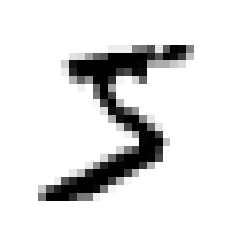

'5'

In [3]:
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
y[0]

`y`의 자료형을 문자열에서 숫자로 바꿔 주자.

In [4]:
import numpy as np
y = y.astype(np.uint8)

데이터를 분석하기 전에는 항상 테스트 세트를 만들어야 한다.
`MNIST`데이터셋은 이미 훈련 세트(앞쪽 60,000개)와 테스트 세트(뒤쪽 10,000개)를 구분해놓았다.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
문제를 단순화해서 하나의 숫자만을 분류하는 이진 분류기를 생각해 볼 수 있다.
예를 들어, 숫자 5를 식별하는 분류기를 만들 수 있다.

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([X_train[0]])

array([ True])

이 분류기는 해당 이미지가 5를 나타낸다고 추측했다(정답).

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정
`cross_val_score()` 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 모델을 평가한다.

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

약 95% 정도로 꽤 높은 정확도가 나왔다.

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_five_clf = Never5Classifier()
cross_val_score(never_five_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

위의 모델은 모든 이미지를 '5 아님' 클래스로 분류하는 모델이다.
이 모델의 정확도는 90% 이상인데, 모든 이미지의 10% 정도만 숫자 `5`이기 때문이다.
이는 정확도로는 모델을 평가하기 어렵다는 것을 의미한다.

### 3.3.2 오차 행렬
오차 행렬의 기본 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 개수를 세는 것이다.

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

위 행렬의 각 요소는 다음과 같다.

| 오차행렬 | 5가 아니라고 예측 | 5라고 예측 |
|--|--|--|
| 실제로 5가 아님 | 진짜 음성(TN) | 거짓 양성(FP) |
| 5 맞음 | 거짓 음성(FN) | 진짜 양성(TP) |

양성 예측의 정확도를 **정밀도**라고 한다.

$$ \text{Precision} = \frac{TP}{TP+FP} $$

분류기가 정확하게 감지한 양성 샘플의 비율을 **재현율**이라고 한다.

$$ \text{Recall} = \frac{TP}{TP+FN} $$

정밀도와 재현율의 조화평균을 **F1 점수**라고 한다.

$$ F_1 = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}} $$

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("정밀도:", precision_score(y_train_5, y_train_pred))
print("재현율:", recall_score(y_train_5, y_train_pred))
print("F1점수:", f1_score(y_train_5, y_train_pred))

정밀도: 0.8370879772350012
재현율: 0.6511713705958311
F1점수: 0.7325171197343846


정밀도와 재현율 관점에서는 모델이 별로 좋지 못하다는 것을 알 수 있다.

### 3.3.4 정밀도/재현율 트레이드오프
정밀도와 재현율은 상황에 맞게 조절할 수 있다.

- **아동용 동영상 분류기**를 만든다고 하면,
실제 유익한 동영상이 제외(낮은 재현율)되더라도 유해한 동영상이 나오지 않는 것(높은 정밀도)이 좋을 수도 있다.

- **감시카메라에서 도둑을 찾는 분류기**를 만든다고 한다면,
잘못된 호출(낮은 정밀도)을 받을 수 있지만 도둑을 더 잘 잡는 것(높은 재현율)이 좋을 수도 있다.

하지만 정밀도와 재현율이 동시에 높은 것은 불가능하다.

`SGDClassifier`은 결정 함수를 이용해서 각 샘플의 점수를 계산하게 된다.
이 점수가 임계값보다 크면 양성, 작으면 음성이 된다.

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [15]:
threshold = 8000    # 임계값
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [16]:
threshold = 0       # 임계값
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

위 예시에서 볼 수 있듯이, 임계값이 높으면 재현율이 줄어든다.

In [17]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                             cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

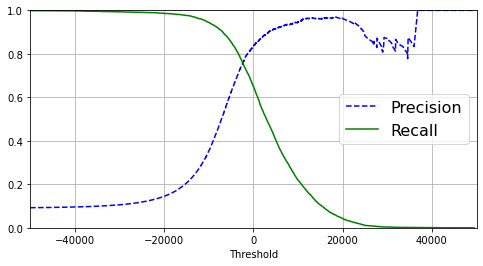

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold")
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

정밀도 90%의 임계값을 구하고, 이를 모델로 만들 수 있다.

In [22]:
threshold_90_percision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_percision

3370.0194991439594

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_percision)
print("정밀도:", precision_score(y_train_5, y_train_pred_90))
print("재현율:",recall_score(y_train_5, y_train_pred_90))

정밀도: 0.9000345901072293
재현율: 0.4799852425751706


## 3.4 다중 분류

